# [Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/page/23/)
The competition dedicated to Tanzania water resources 

- **REMADE** `amount_tsh` - Total static head (amount water available to waterpoint)
- **REMADE** `date_recorded` - The date the row was entered
- **REMADE** `funder` - Who funded the well
- **FIXED** `gps_height` - Altitude of the well
- **REMADE** `installer` - Organization that installed the well
- **FIXED** `longitude` - GPS coordinate
- **FIXED** `latitude` - GPS coordinate
- **REMADE** `wpt_name` - Name of the waterpoint if there is one
- **DROPPED** `num_private` -
- **REMADE** `basin` - Geographic water basin
- **REMADE** `subvillage` - Geographic location
- **REMADE** `region` - Geographic location
- **DROPPED** `region_code` - Geographic location (coded)
- **DROPPED** `district_code` - Geographic location (coded)
- **REMADE** `lga` - Geographic location
- **REMADE** `ward` - Geographic location
- **FIXED** `population` - Population around the well
- **FIXED** `public_meeting` - True/False
- **DROPPED** `recorded_by` - Group entering this row of data
- **REMADE** `scheme_management` - Who operates the waterpoint
- **DROPPED** `scheme_name` - Who operates the waterpoint
- **FIXED** `permit` - If the waterpoint is permitted
- **REMADE** `construction_year` - Year the waterpoint was constructed
- **REMADE** `extraction_type` - The kind of extraction the waterpoint uses
- **DROPPED** `extraction_type_group` - The kind of extraction the waterpoint uses
- **REMADE** `extraction_type_class` - The kind of extraction the waterpoint uses
- **REMADE** `management` - How the waterpoint is managed
- **REMADE** `management_group` - How the waterpoint is managed
- **REMADE** `payment` - What the water costs
- **DROPPED** `payment_type` - What the water costs
- **REMADE** `water_quality` - The quality of the water
- **DROPPED** `quality_group` - The quality of the water
- **REMADE** `quantity` - The quantity of water
- **DROPPED** `quantity_group` - The quantity of water
- **REMADE** `source` - The source of the water
- **DROPPED** `source_type` - The source of the water
- **REMADE** `source_class` - The source of the water
- **REMADE** `waterpoint_type` - The kind of waterpoint
- **DROPPED** `waterpoint_type_group` - The kind of waterpoint

In [10]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy import array, newaxis

In [11]:
plt.style.use('ggplot')

In [12]:
train = pd.read_csv('data/train.csv')
labels = pd.read_csv('data/labels.csv')
test = pd.read_csv('data/test.csv')

In [13]:
print(train.shape)
print(labels.shape)
print(test.shape)

(59400, 40)
(59400, 2)
(14850, 40)


I concatenate train and test datasets into one to make changes to both simultaneously.

The ***Test*** column is created to remember which rows belong where


In [16]:
train['Test'] = False
test['Test'] = True

In [17]:
data = pd.concat([train, test], ignore_index=True)

## In search of NAs...

In [18]:
data.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    4504
gps_height                   0
installer                 4532
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 470
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            4155
recorded_by                  0
scheme_management         4846
scheme_name              35258
permit                    3793
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

---
### Let's look closely at these variables
- `Total static head` (amount water available to waterpoint)

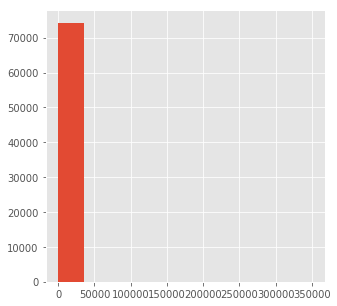

In [19]:
%matplotlib inline
data.amount_tsh.hist(figsize=(5,5))
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [6,6]

In [20]:
round(sum(data.amount_tsh==0)/len(data), 3)

0.701

- So, 70% of amount of water data is missing

In [21]:
data['amount_tsh'].fillna(-1, inplace=True)

---
## It`s plotting time!
### Coordinates

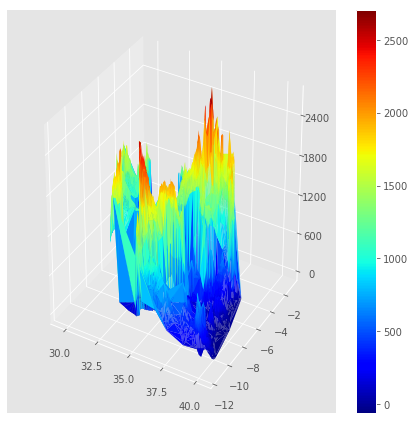

In [17]:
Xs = data.longitude[data.longitude!=0]
Ys = data.latitude[data.longitude!=0]
Zs = data.gps_height[data.longitude!=0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.show() 

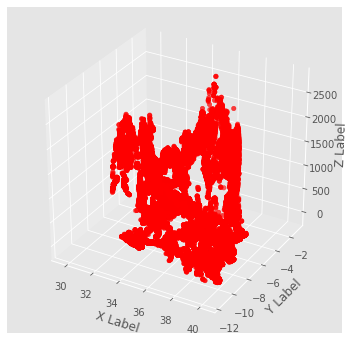

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =list(data.longitude[data.longitude!=0])
y =list(data.latitude[data.longitude!=0])
z =list(data.gps_height[data.longitude!=0])

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

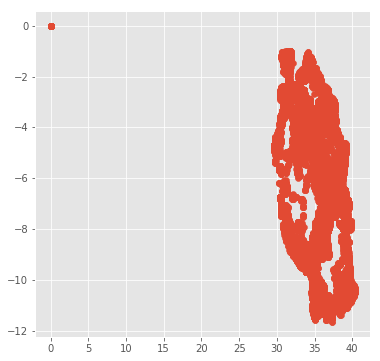

In [19]:
plt.scatter(data.longitude, data.latitude)

It appears, that we have some (2269 to be precise) odd values of coordinates that equal zero. 457 of them belong to test data. 

**Something has to be done!** 

- The idea is to get the mean coordinate values of geolocations where the current pump is and make them the values of the missing points.

In [22]:
for locat in data.lga.unique():
    if sum(data.longitude[data.lga==locat]==0) > 0:
        print(locat)

Bariadi
Geita
Magu


In [23]:
def get_mean(location, coordinate):
    if coordinate=='longitude':
        if location == 'Geita':
            return 32.189252  # exact coordinates of Geita
        else:
            return data.longitude[(data.lga==location)&(data.longitude!=0)].mean()
    else:
        if location == 'Geita':
            return -2.8871061 # exact coordinates of Geita
        return data.latitude[(data.lga==location)&(data.latitude<-0.0000001)].mean()
    
for locat in ['Bariadi', 'Geita', 'Magu']:   
    data.loc[data.index[(data.longitude==0)&(data.lga==locat)], 'longitude'] = get_mean(locat, 'longitude')
    data.loc[data.index[(data.latitude>-0.0000001)&(data.lga==locat)], 'latitude'] = get_mean(locat, 'latitude')

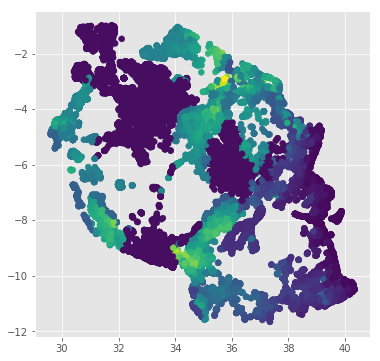

In [22]:
plt.scatter(data.longitude, data.latitude, c=data.gps_height)

- While we are here with lga, let's add a column *'lga_freq'* to dataset to remember the relative frequences of the geographic location

In [24]:
lgas = data.lga.value_counts(normalize=True).to_dict()
data['lga_freq'] = data.lga.apply(lambda x: lgas[x])

Now that we have fixed the longitute and latitude, let`s change the ***gps_height*** since there are many values with zeroes

- This function takes an array of coordinates (in a nessessary format) and returns an array of elevations 

In [213]:
import requests
import pandas as pd

with open("key.txt", 'r') as f:
    key = f.read()

# script for returning elevation from lat, long, based on open elevation data
# which in turn is based on SRTM
def get_elevation(lat, long):
    query = (
        'https://maps.googleapis.com/maps/api/elevation/json?locations={lat},{long}&key={key}'
    )
    r = requests.get(query.format(lat=lat, long=long, key=key)).json()  # json object, various ways you can extract value
    # one approach is to use pandas json functionality:
    
    return r['results'][0]['elevation']

In [49]:
get_elevation(39.7391536,-104.9847034)

1608.637939453125

In [52]:
from tqdm import tqdm_notebook
import time

In [55]:
len(data[data.gps_height==0])

25649

In [57]:
heights = []
for lat, long in tqdm_notebook(zip(data[data.gps_height==0].latitude, data[data.gps_height==0].longitude)):
    try:
        heights.append(get_elevation(lat, long))
        time.sleep(0.01)
    except:
        print("Waiting refresh")
        time.sleep(60)

In [58]:
data.gps_height[data.gps_height==0] = heights

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Elevation map of pumps')

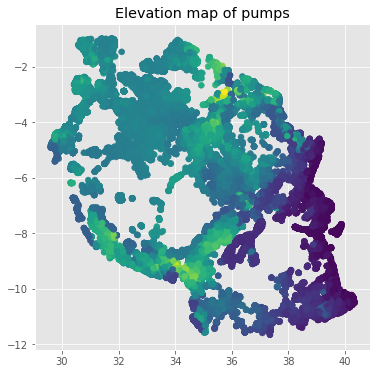

In [59]:
plt.scatter(data.longitude, data.latitude, c=data.gps_height)
plt.title("Elevation map of pumps")

In [60]:
data.to_csv("gps_clean.csv")

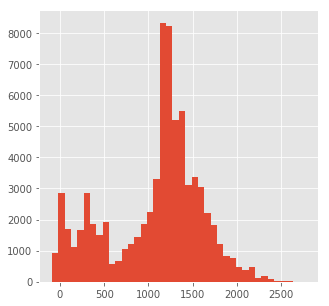

In [61]:
data.gps_height.hist(bins=40, figsize=(5,5))

### Hurrah! Coordinates are fixed

---
### Status
- Let`s see, how many pumps are pumping it!

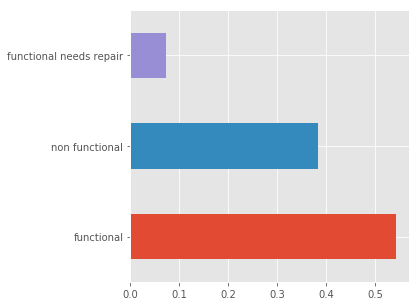

In [62]:
(labels.status_group.value_counts()/len(labels)).plot(kind='barh', figsize=(5,5));

Less than 10% of pumps need repair, that`ll be tough to predict this category

- Here I create new column in my **train** dataset where I keep the status of the pump (as a label)

In [63]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(labels.status_group)
train['Status'] = y

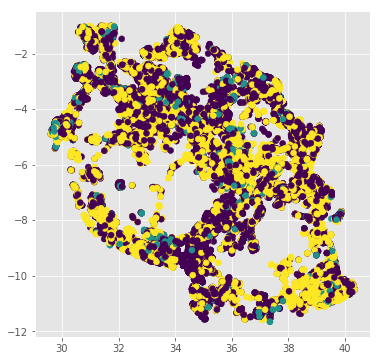

In [65]:
plt.scatter(train.longitude[train.longitude!=0], train.latitude[train.longitude!=0], c=train.Status[train.longitude!=0])

---
### Next stop - date!

In [66]:
data.date_recorded[1:10]

1    2013-03-06
2    2013-02-25
3    2013-01-28
4    2011-07-13
5    2011-03-13
6    2012-10-01
7    2012-10-09
8    2012-11-03
9    2011-08-03
Name: date_recorded, dtype: object

In [67]:
dates = data.date_recorded.astype(np.datetime64)

In [68]:
data['Year'] = dates.apply(lambda x: x.year)
data['Month'] = dates.apply(lambda x: x.month)
data['Day'] = dates.apply(lambda x: x.day)

From the newly aquired *'Month'* variable I want to get some more info. Let's have a look at the rain precipitation distribution of Tanzania. They have two *dry* seasons - one short from January to February, one long - June to September, and two *rain* seasons - March to May and October to December. 

That might be a nice feature for the broken pumps since the correspondent rows could be added to the dataset right after the pump's failure

![](https://weather-and-climate.com/uploads/average-rainfall-tanzania-dar-es-salaam.png) 

In [69]:
def get_season(month):
    if month < 3:
        season = 'dry_1'
    elif 2<month<6:
        season = 'rain_1'
    elif 5<month<10:
        season = 'dry_2'
    else:
        season = 'rain_2'
    return season

In [70]:
for month in data.Month.unique():
    data.loc[data.index[data.Month==month], 'Season'] = get_season(month)

In [71]:
data.Season = le.fit_transform(data.Season)

In [72]:
data.drop('date_recorded', axis=1, inplace=True)

---
### Construction year
- Construction year has 25969 (*34,98%*) zero values. Somehow we should get the age of the pump out of these

In [73]:
round(sum(data.construction_year==0)/len(data), 4)

0.3498

Text(0.5, 1.0, 'Histogram of construction year')

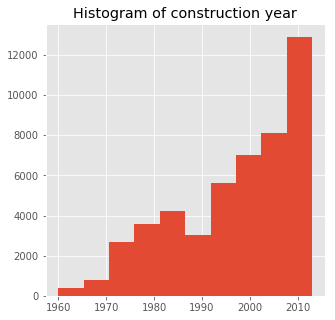

In [74]:
data.construction_year[data.construction_year!=0].hist(bins=10, figsize=(5,5))
plt.title("Histogram of construction year")

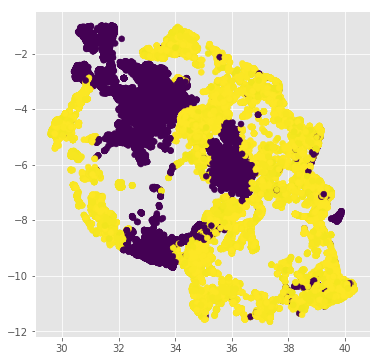

In [75]:
plt.scatter(data.longitude, data.latitude, c=data.construction_year)

- Once again the **non random** pattern of missing data can be observed - the same points where there were no gps_heigt data now miss the construction year values...

The idea is to replace the zeroes with some adequate estimates of the construction year, aquired from variuos variables of the dataset. For example, the **mean values** of construction year by wards (geolocations), then the 15% and 25% **percentiles** of construction year by installer and funder companies. Those percentiles were chosen empirically to match more or less closely the original histogram of construction years.

- Function that gets value of construction year

In [76]:
def get_year(value, flag):
    if flag == 'wards':
        year = float(data.construction_year[(data.ward==value)&(data.const_year!=0)].mean()//1)
    elif flag =='scheme':
        year = float(data.construction_year[(data.scheme_name==value)&(data.const_year!=0)].mean()//1)
    elif flag == 'install':
        year = float(np.percentile(data.const_year[(data.installer==value)&(data.const_year!=0)], 15)//1)
    else:
        year = float(np.percentile(data.const_year[(data.funder==value)&(data.const_year!=0)], 25)//1)
    return year

- Creating the *'const_year'* column in the dataset to fill it with new construction year values

In [77]:
data['const_year'] = data.construction_year[:]

### Wards (geolocation)
The intuition is - closely situated pumps might have been built in approximately the same time period. That is a weak assumption, but anyways I try

Let`s have a look at how mean year values from wards are distributed

Text(0.5, 1.0, 'Distribution of mean construction years from wards')

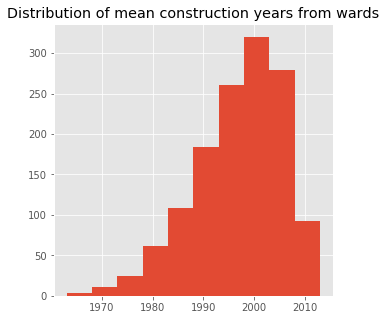

In [78]:
wards = []
for ward in data.ward.unique():
    wards.append(data.construction_year[(data.ward==ward)&(data.construction_year!=0)].mean())

pd.DataFrame(wards).hist(figsize=(5,5))
plt.title("Distribution of mean construction years from wards")

Now add the mean values from wards to the const_year column

In [79]:
for ward in data.ward.unique():
    try:
        const_year = get_year(ward, 'wards')
        if str(const_year)!='nan':
            data.loc[data.index[(data.const_year==0)&(data.ward==ward)], 'const_year'] = int(const_year)
    except:
        continue
sum(data.const_year==0)

23474

> While we are working with wards, let's create a column *'wards_freq'* and fill it with frequencies of (suddenly) wards

In [80]:
geo_wards = data.ward.value_counts(normalize=True).to_dict()
data['wards_freq'] = data.ward.apply(lambda x: geo_wards[x])

In [81]:
data.drop(['ward'], axis = 1, inplace = True)

---
### Schemes
Now I check the "Who operates the waterpoint" variable. It sounds logical that companies, that operate several pumps might have started doing so in relatively close time periods

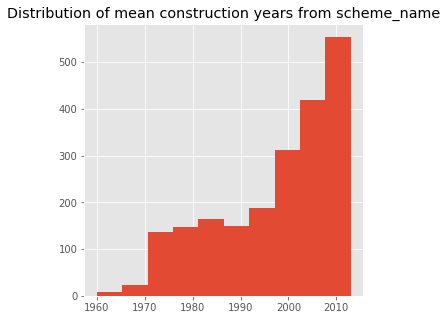

In [82]:
schemes = []
for name in data.scheme_name.unique():
    schemes.append(data.construction_year[(data.scheme_name==name)&(data.construction_year!=0)].mean())
pd.DataFrame(schemes).hist(figsize=(5,5))
plt.title("Distribution of mean construction years from scheme_name");

In [83]:
for name in data.scheme_name.unique():
    try:
        const_year = get_year(name, 'scheme')
        if str(const_year)!='nan' and const_year >= 1960:
            data.loc[data.index[(data.const_year==0)&(data.scheme_name==name)], 'const_year'] = int(const_year)
    except:
        continue
sum(data.const_year==0)

22952

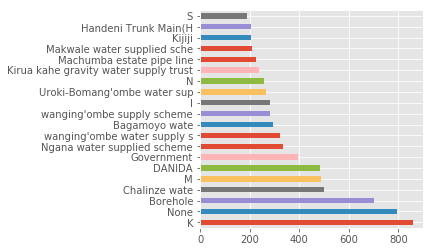

In [84]:
data.scheme_name.value_counts()[:20].plot(kind='barh', figsize=(4,4))

In [85]:
data.scheme_name.isnull().sum()

35258

In [88]:
scheme_name = data.scheme_name.fillna(-1).value_counts(normalize=True).to_dict()
data['scheme_name_freq'] = data.scheme_name.fillna(-1).apply(lambda x: scheme_name[x])

> Almost 50% of *`data_scheme_name`* are missing, seems like I'll have to drop the column

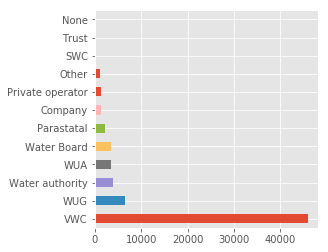

In [89]:
data.scheme_management.value_counts().plot(kind='barh', figsize=(4,4))

In [90]:
data.scheme_management.isnull().sum()

4846

In [91]:
def get_scheme(lat, long):
    i = np.argmin(((data.latitude[(data.scheme_management.notnull())&(data.scheme_management!='None')]-lat)**2 +\
                   (data.longitude[(data.scheme_management.notnull())&(data.scheme_management!='None')]-long)**2)**0.5)
    return data.scheme_management[i]

In [92]:
for i in data.index[(data.scheme_management.isnull())|(data.scheme_management=='None')]:
    data.loc[data.index[i], 'scheme_management'] = get_scheme(data.latitude[i], data.longitude[i])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [93]:
# scheme_freq = data.scheme_management.value_counts(normalize=True).to_dict()
# data['scheme_freq'] = data.scheme_management.apply(lambda x: scheme_freq[x])

In [94]:
data['scheme_VWC'] = data.scheme_management=='VWC'

---
### Funder
The funder organization could have been active during a certaing period of time which again gives information about the construction year

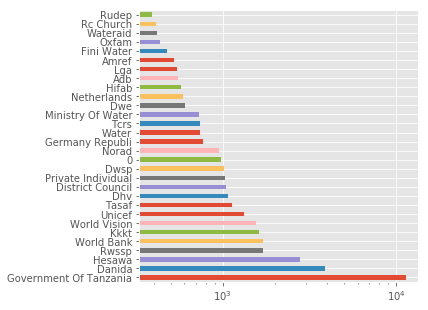

In [96]:
data.funder.value_counts()[:30].plot(kind="barh", figsize=(5,5))
plt.xscale('log');

In [97]:
for funder in data.funder.unique():
    try:
        const_year = get_year(funder, 'funder')
        if str(const_year)!='nan':
            data.loc[data.index[(data.const_year==0)&(data.funder==funder)], 'const_year'] = int(const_year)
    except:
        continue

In [98]:
sum(data.const_year==0)

6130

In [99]:
sum(data.funder.isnull())+sum(data.funder=='0')

5484

> Funder company might have operated in one area, so I'll restore the missing 5484 values based on that assumption

In [100]:
def get_funder(lat, long):
    i = np.argmin(((data.latitude[(data.funder!='0')&(data.funder.notnull())]-lat)**2 +\
                   (data.longitude[(data.funder!='0')&(data.funder.notnull())]-long)**2)**0.5)
    return data.funder[i]

In [101]:
for i in data.index[(data.funder.isnull())|(data.funder=='0')]:
    data.loc[data.index[i], 'funder'] = get_funder(data.latitude[i], data.longitude[i])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [102]:
funders = data.funder.value_counts(normalize=True).to_dict()
data['funder_freq'] = data.funder.apply(lambda x: funders[x])

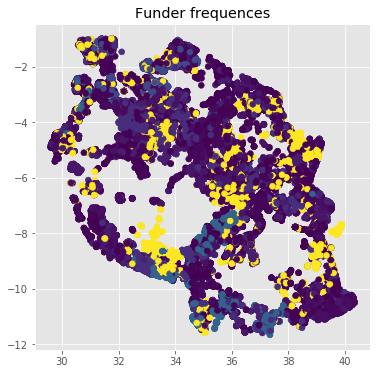

In [103]:
plt.scatter(data.longitude, data.latitude, c=data.funder_freq)
plt.title('Funder frequences');

### Installer
The same goes for installer company - it could mainly work during some period of time

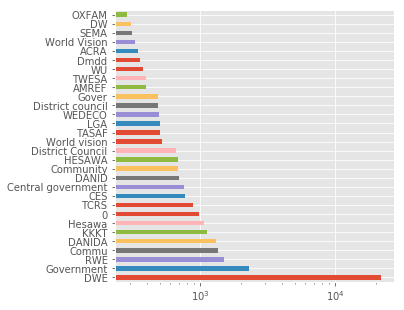

In [104]:
data.installer.value_counts()[:30].plot(kind="barh", figsize=(5,5))
plt.xscale('log');

In [105]:
for install_comp in data.installer.unique():
    try:
        const_year = get_year(install_comp, 'install')
        if str(const_year)!='nan':
            data.loc[data.index[(data.const_year==0)&(data.installer==install_comp)], 'const_year'] = int(const_year)
    except:
        continue
sum(data.const_year==0)

3641

In [106]:
data.installer.isnull().sum()+sum(data.installer=='0')

5512

> Installer company again might have operated in one area

In [107]:
def get_installer(lat, long):
    i = np.argmin(((data.latitude[(data.installer!='0')&(data.installer.notnull())]-lat)**2 +\
                   (data.longitude[(data.installer!='0')&(data.installer.notnull())]-long)**2)**0.5)
    return data.installer[i]
for i in data.index[(data.installer.isnull())|(data.installer=='0')]:
    data.loc[data.index[i], 'installer'] = get_funder(data.latitude[i], data.longitude[i])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [108]:
installers = data.installer.value_counts(normalize=True).to_dict()
data['installer_freq'] = data.installer.apply(lambda x: installers[x])

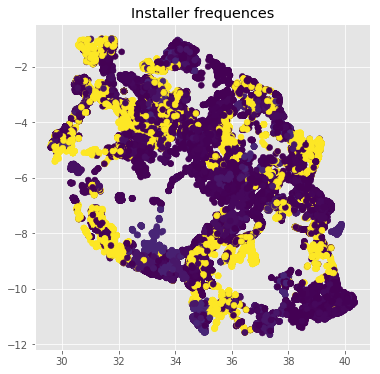

In [109]:
plt.scatter(data.longitude, data.latitude, c=data.installer_freq)
plt.title('Installer frequences');

- Finally, we have 3641 missing values of construction year. I'll just assign mean region year to them

In [110]:
for region in data.lga.unique():
    value = data.const_year[(data.lga==region)&(data.const_year!=0)&(data.const_year.notnull())].mean()
    data.loc[data.index[(data.const_year==0)&(data.lga==region)], 'const_year'] = value
    data.loc[data.index[(data.const_year.isnull())&(data.lga==region)], 'const_year'] = value
sum((data.const_year==0)|(data.const_year.isnull()))

112

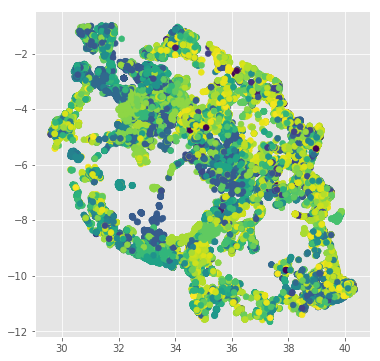

In [111]:
plt.scatter(
    data.longitude[data.const_year!=0], 
    data.latitude[data.const_year!=0], 
    c=data.const_year[data.const_year!=0]
);

There we go! Nice and beautiful map

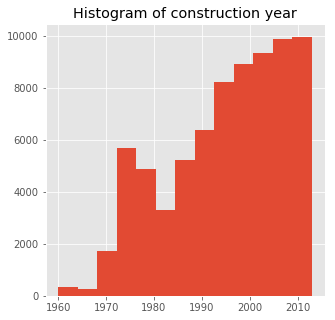

In [112]:
data.const_year.hist(bins=13, figsize=(5,5))
plt.title("Histogram of construction year");

The histogram somewhat represents the initial one

Now I create the variable *'WorkYear'* that represents for how many years have the pump been working. Some values turn out to be negative, so I replace them with 1 instead

In [113]:
data["WorkYear"] = data.Year-data.const_year
data.loc[data.index[data.WorkYear<=0], 'WorkYear'] = 1

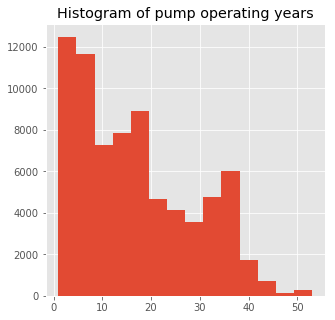

In [114]:
data.WorkYear.hist(bins=14, figsize=(5,5))
plt.title("Histogram of pump operating years");

## It's over, it's done! The years have been prepared

---
### Regions and villages

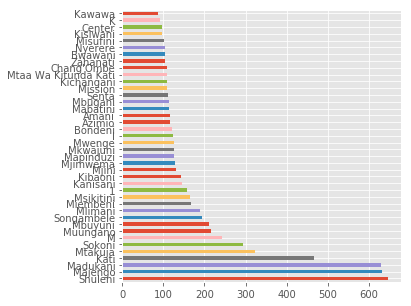

In [115]:
data.subvillage.value_counts()[:40].plot(kind="barh", figsize=(5,5));

In [116]:
def get_subvillage(lat, long):
    i = np.argmin(((data.latitude[data.subvillage.notnull()]-lat)**2 +\
                   (data.longitude[data.subvillage.notnull()]-long)**2)**0.5)
    return data.subvillage[i]

In [117]:
for i in data.index[data.subvillage.isnull()]:
    data.loc[data.index[i], 'subvillage'] = get_subvillage(data.latitude[i], data.longitude[i])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Replace the name of the village with its relative frequency

In [119]:
subvill_freq = data.subvillage.value_counts(normalize=True).to_dict()
for key in tqdm_notebook(subvill_freq):
    data.loc[data.index[data.subvillage==key], 'Subvill_freq'] = subvill_freq[key]

---
### Now population!
- Population around the well

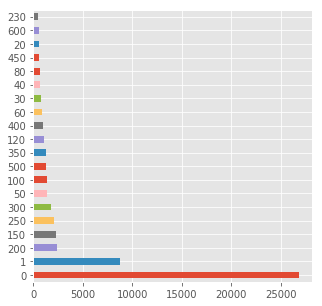

In [127]:
data.population.value_counts()[:20].plot(kind="barh", figsize=(5,5));

There are too many observations where populations is either 0 or 1. Suspicious, eh? Someone might have been way too lazy to fill in the dataset. 

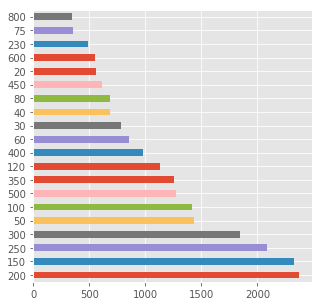

In [121]:
data.population[data.population>1].value_counts()[:20].plot(kind="barh", figsize=(5,5));

To restore the missing points I use the mean population of the nearest non-empty values that lie in the circle of radius 0.5. In case there are no such values - increase the radius of search

In [122]:
def get_nearest_population(lat, long):
    condition_lat = data.latitude[(data.population!=0)&(data.population.notnull())&(data.population!=1)]
    condition_long = data.longitude[(data.population!=0)&(data.population.notnull())&(data.population!=1)]
    distance = ((condition_lat-lat)**2 + (condition_long-long)**2)**0.5
    
    radius = 0.5
    i = np.argwhere((distance < radius))
    value = data.population[pd.DataFrame(i)[0]][(data.population!=0)&(data.population.notnull())&(data.population!=1)].mean()
    while str(value) == 'nan':
        radius += 0.1
        i = np.argwhere((distance < radius))
        value = data.population[pd.DataFrame(i)[0]][(data.population!=0)&(data.population.notnull())&(data.population!=1)].mean()
    return value

Creating the *'population_near'* column

In [123]:
data['population_near'] = data.population[:]

In [124]:
for i in tqdm_notebook(data.index[(data.population==0)|(data.population.isnull())|(data.population==1)]):
    data.loc[data.index[i], 'population_near'] = get_nearest_population(data.latitude[i], data.longitude[i])
sum(data.population_near.isnull())

0

This thing takes a loooong time...

Here is an [article](http://www.bbc.com/news/world-africa-14095776) about Tanzania from BBC to read while waiting <3

In [125]:
sum(data.population_near.isnull())

0

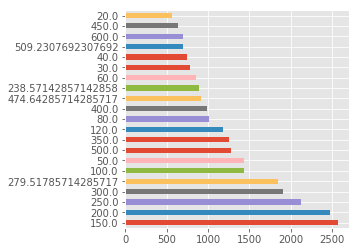

In [126]:
data.population_near.value_counts()[:20].plot(kind='barh', figsize = (4,4));

### Done!

---
### Basin
- Geographic water basin

In [128]:
basins = le.fit_transform(data.basin)
data['basin_lev'] = basins

In [129]:
data.drop(['basin'], axis=1, inplace=True)

Text(0.5, 1.0, 'Basin map')

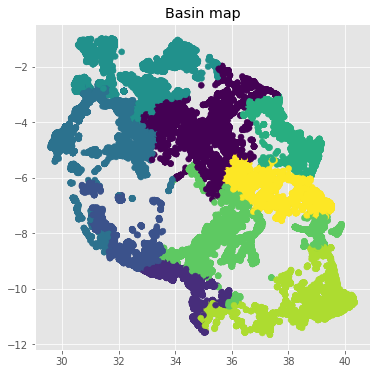

In [130]:
plt.scatter(data.longitude, data.latitude, c=data.basin_lev)
plt.title('Basin map')

---
### Water quality

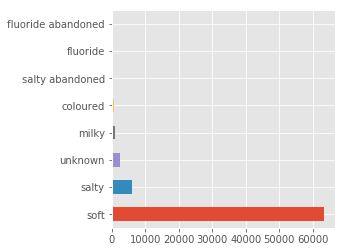

In [131]:
data.water_quality.value_counts().plot(kind='barh', figsize=(4,4));

Some of the values are unknown. Since water quality depends mainly on the area and geological peculiarities, I'll restore the values by assigning to them the water quality of the nearest pumps

In [132]:
def get_nearest_quality(lat, long):
    i = np.argmin(((data.latitude[data.water_quality!='unknown']-lat)**2 +\
                   (data.longitude[data.water_quality!='unknown']-long)**2)**0.5)
    return data.water_quality[i]

In [133]:
for i in data.index[data.water_quality=='unknown']:
    data.loc[data.index[i], 'water_quality'] = get_nearest_quality(data.latitude[i], data.longitude[i])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [134]:
data.water_quality.value_counts()

soft                  65462
salty                  6342
milky                  1093
coloured                636
salty abandoned         444
fluoride                249
fluoride abandoned       24
Name: water_quality, dtype: int64

There we go, no more unknown values. Now normalize the frequencies and add them to the *'Water_qual_freq'* column

In [135]:
data['water_quality_group'] = le.fit_transform(data.water_quality)

In [136]:
water_qual = data.water_quality.value_counts(normalize=True).to_dict()
data['Water_qual_freq'] = data.water_quality.apply(lambda x: water_qual[x])

In [137]:
data.drop(['quality_group', 'water_quality'], axis = 1, inplace = True)

---
### Water quantity

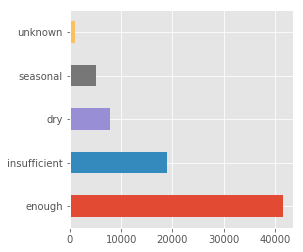

In [138]:
data.quantity.value_counts().plot(kind='barh', figsize=(4,4));

Some values are unknown, but water quantity depends on the region, so I'll restore it based on the nearest non-empty value pump

In [139]:
def get_nearest_water_quantity(lat, long):
    i = np.argmin(((data.latitude[data.quantity!='unknown']-lat)**2 +\
                   (data.longitude[data.quantity!='unknown']-long)**2)**0.5)
    return data.quantity[i]

In [140]:
for i in data.index[data.quantity=='unknown']:
    data.loc[data.index[i], 'quantity'] = get_nearest_water_quantity(data.latitude[i], data.longitude[i])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


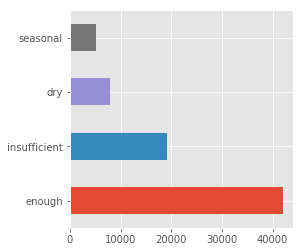

In [141]:
data.quantity.value_counts().plot(kind='barh', figsize = (4,4));

In [142]:
data['quantity_lev'] = le.fit_transform(data.quantity)

In [143]:
data.drop(['quantity', 'quantity_group'], axis=1, inplace=True)

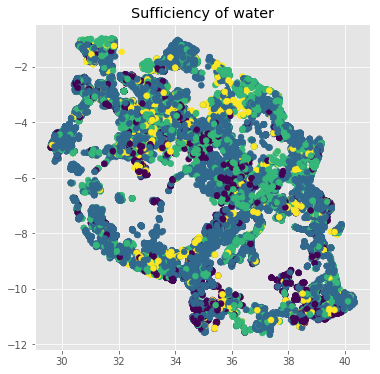

In [146]:
plt.scatter(data.longitude, data.latitude, c=data.quantity_lev)
plt.title('Sufficiency of water');

---
### Source of water

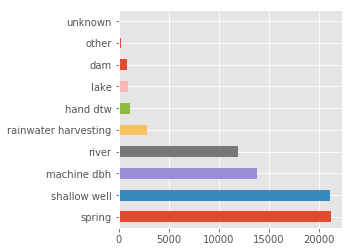

In [147]:
data.source.value_counts().plot(kind='barh', figsize=(4,4));

Restoring the unknown and other values

In [148]:
def get_nearest_source(lat, long):
    i = np.argmin(((data.latitude[(data.source!='unknown')&(data.source!='other')]-lat)**2 +\
                   (data.longitude[(data.source!='unknown')&(data.source!='other')]-long)**2)**0.5)
    return data.source[i]

In [149]:
for i in data.index[(data.source=='unknown')|(data.source=='other')]:
    data.loc[data.index[i], 'source'] = get_nearest_source(data.latitude[i], data.longitude[i])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


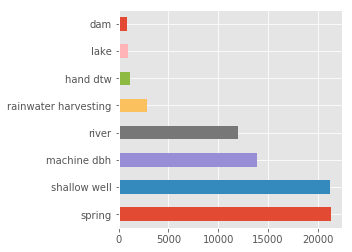

In [150]:
data.source.value_counts().plot(kind='barh', figsize=(4,4));

In [151]:
sources = le.fit_transform(data.source)
data['source_lev'] = sources

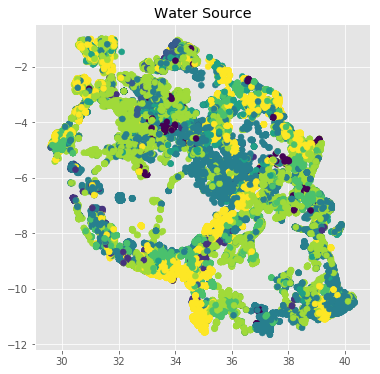

In [152]:
plt.scatter(data.longitude, data.latitude, c=data.source_lev)
plt.title('Water Source');

In [153]:
data.drop(['source', 'source_type'], axis = 1, inplace = True)

---
### Source Class

In [154]:
def get_nearest_source_class(lat, long):
    i = np.argmin(((data.latitude[data.source_class!='unknown']-lat)**2 +\
                   (data.longitude[data.source_class!='unknown']-long)**2)**0.5)
    return data.source_class[i]

In [155]:
for i in data.index[(data.source_class=='unknown')]:
    data.loc[data.index[i], 'source_class'] = get_nearest_source_class(data.latitude[i], data.longitude[i])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [156]:
source_classes = le.fit_transform(data.source_class)
data['source_class_lev'] = source_classes

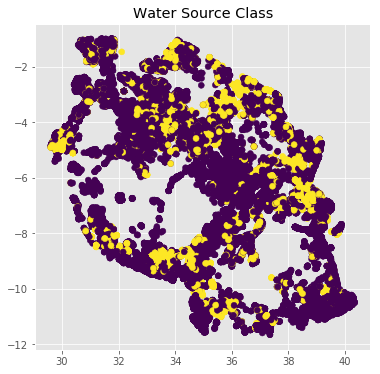

In [157]:
plt.scatter(data.longitude, data.latitude, c=data.source_class_lev)
plt.title('Water Source Class');

In [158]:
data.drop(['source_class'], axis=1, inplace = True)

---
### Waterpoint type

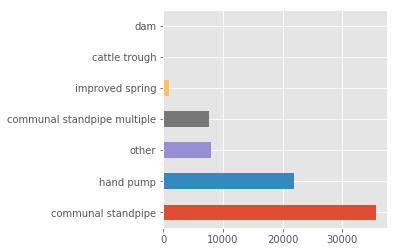

In [159]:
data.waterpoint_type.value_counts().plot(kind='barh', figsize=(4,4));

In [160]:
def get_nearest_type(lat, long):
    i = np.argmin(((data.latitude[data.waterpoint_type!='other']-lat)**2 +\
                   (data.longitude[data.waterpoint_type!='other']-long)**2)**0.5)
    return data.waterpoint_type[i]

In [161]:
for i in data.index[(data.waterpoint_type=='other')]:
    data.loc[data.index[i], 'waterpoint_type'] = get_nearest_type(data.latitude[i], data.longitude[i])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [162]:
water_types = le.fit_transform(data.waterpoint_type)
data['waterpoint_type_lev'] = water_types

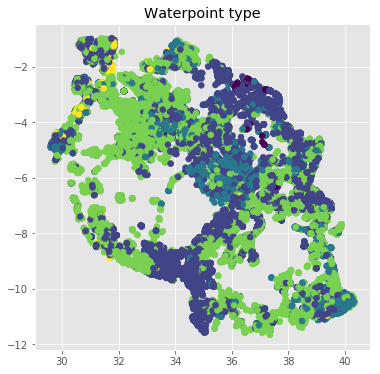

In [163]:
plt.scatter(data.longitude, data.latitude, c=data.waterpoint_type_lev)
plt.title('Waterpoint type');

In [164]:
data.drop(['waterpoint_type', 'waterpoint_type_group'], axis=1, inplace=True)

---
### Payment

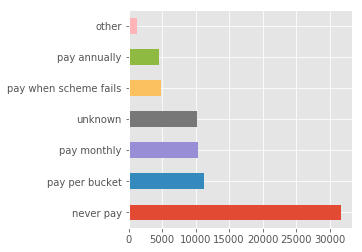

In [165]:
data.payment.value_counts().plot(kind='barh', figsize=(4,4));

Payment might depend on the current management company (and management company might set the same type of payments for same regions)

In [166]:
def get_payment(company, lat, long):
    try:
        conditions = (data.payment_type!='other')&(data.payment_type!='unknown')&(data.scheme_name==company)
    
        i = np.argmin(((data.latitude[conditions]-lat)**2 +\
                       (data.longitude[conditions]-long)**2)**0.5)
    except:
        conditions = (data.payment_type!='other')&(data.payment_type!='unknown')
        i = np.argmin(((data.latitude[conditions]-lat)**2 +\
                       (data.longitude[conditions]-long)**2)**0.5)
    return data.payment_type[i]

In [167]:
for i in data.index[(data.payment_type=='other')|(data.payment_type=='unknown')]:
    data.loc[data.index[i], 'payment_type'] = get_payment(data.scheme_name[i], data.latitude[i], data.longitude[i])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [168]:
data.payment_type.value_counts()

never pay     36450
per bucket    15093
monthly       11629
on failure     5872
annually       5206
Name: payment_type, dtype: int64

In [169]:
payment_types = le.fit_transform(data.payment_type)
data['payment_type_lev'] = payment_types

In [170]:
data.drop(['payment', 'payment_type'], axis=1, inplace=True)

---
### WPT name

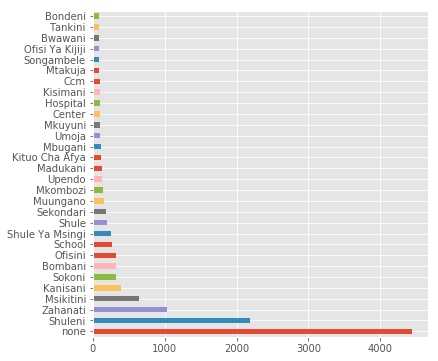

In [171]:
data.wpt_name.value_counts()[:30].plot(kind='barh');

In [172]:
(data.wpt_name=='none').sum()

4440

- Well, I definitely can't restore the names of the pumps, so I just create several columns in dataset to track the presence of name, its length and frequency

In [173]:
data['HasName'] = (data.wpt_name!='none').astype(int)

In [174]:
name_freq = data.wpt_name.value_counts(normalize=True).to_dict()
data['NameFreq'] = data.wpt_name.apply(lambda x: name_freq[x])

---
### Num private
*The misterious variable...*

In [175]:
data.num_private.value_counts()[:10]

0     73299
1        94
6        92
5        60
8        58
15       47
32       45
45       41
3        38
93       37
Name: num_private, dtype: int64

*...goes to junk!*

In [176]:
data.drop(['num_private'], axis=1, inplace=True)

---
### Region

In [177]:
region_freq = data.region.value_counts(normalize=True).to_dict()
data['region_freq'] = data.region.apply(lambda x: region_freq[x])

In [178]:
regions = le.fit_transform(data.region)
data['region_lev'] = regions

---
### Public meeting

In [179]:
data.public_meeting.isnull().sum()

4155

In [180]:
def get_meeting(lat, long):
    i = np.argmin(((data.latitude[data.public_meeting.notnull()]-lat)**2 +\
                   (data.longitude[data.public_meeting.notnull()]-long)**2)**0.5)
    return data.public_meeting[i]

In [181]:
for i in data.index[(data.public_meeting.isnull())]:
    data.loc[data.index[i], 'public_meeting'] = get_meeting(data.latitude[i], data.longitude[i])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


---
### Permit

In [182]:
def get_permit(lat, long):
    i = np.argmin(((data.latitude[data.permit.notnull()]-lat)**2 +\
                   (data.longitude[data.permit.notnull()]-long)**2)**0.5)
    return data.permit[i]

In [183]:
for i in data.index[(data.permit.isnull())]:
    data.loc[data.index[i], 'permit'] = get_permit(data.latitude[i], data.longitude[i])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


---
### Recorded by

In [184]:
data.recorded_by.value_counts()

GeoData Consultants Ltd    74250
Name: recorded_by, dtype: int64

Now that's an informative variable if ever I did see one! 

In [185]:
data.drop(['recorded_by'], axis=1, inplace=True)

---
### Extraction 

In [186]:
data.extraction_type.value_counts()

gravity                      33263
nira/tanira                  10205
other                         8102
submersible                   5982
swn 80                        4588
mono                          3628
india mark ii                 3029
afridev                       2208
ksb                           1790
other - rope pump              572
other - swn 81                 284
windmill                       152
india mark iii                 135
cemo                           108
other - play pump              101
walimi                          60
climax                          41
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [187]:
extraction_freq = data.extraction_type.value_counts(normalize=True).to_dict()
data['extraction_freq'] = data.extraction_type.apply(lambda x: extraction_freq[x])

In [188]:
data.extraction_type_class.value_counts()

gravity         33263
handpump        20612
other            8102
submersible      7772
motorpump        3777
rope pump         572
wind-powered      152
Name: extraction_type_class, dtype: int64

In [189]:
data['extraction_lev'] = le.fit_transform(data.extraction_type_class)

In [190]:
data.drop(['extraction_type', 'extraction_type_class', 'extraction_type_group'], axis=1, inplace=True)

---
### Management

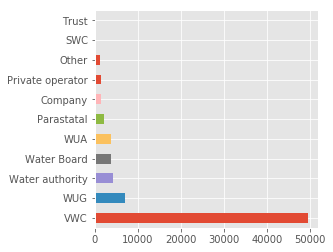

In [191]:
data.scheme_management.value_counts().plot(kind='barh', figsize=(4,4));

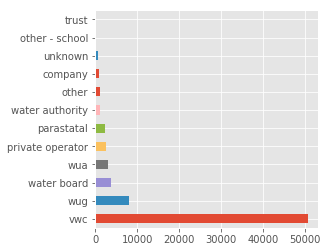

In [192]:
data.management.value_counts().plot(kind='barh', figsize=(4,4));

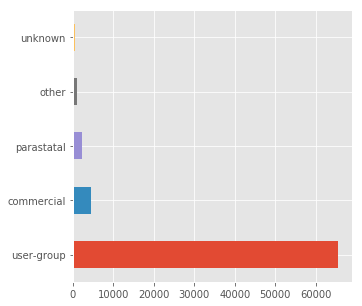

In [193]:
data.management_group.value_counts().plot(kind='barh', figsize=(5,5));

In [194]:
def get_management(lat, long, flag):
    if flag == 'group':
        i = np.argmin(((data.latitude[data.management_group!='unknown']-lat)**2 +\
                       (data.longitude[data.management_group!='unknown']-long)**2)**0.5)
        return data.management_group[i]
    else:
        i = np.argmin(((data.latitude[data.management!='unknown']-lat)**2 +\
                       (data.longitude[data.management!='unknown']-long)**2)**0.5)
        return data.management[i]

In [195]:
for i in data.index[(data.management=='unknown')]:
    data.loc[data.index[i], 'management'] = get_management(data.latitude[i], data.longitude[i], 'management')

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [196]:
for i in data.index[(data.management_group=='unknown')]:
    data.loc[data.index[i], 'management_group'] = get_management(data.latitude[i], data.longitude[i], 'group')

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [197]:
data['management_group_lev'] = le.fit_transform(data.management_group)

In [198]:
management_freq = data.management.value_counts(normalize=True).to_dict()
data['management_freq'] = data.management.apply(lambda x: management_freq[x])

In [199]:
data.drop(['management', 'management_group'], axis=1, inplace=True)

In [200]:
data.isnull().sum()

id                          0
amount_tsh                  0
funder                      0
gps_height                  0
installer                   0
longitude                   0
latitude                    0
wpt_name                    0
subvillage                  0
region                      0
region_code                 0
district_code               0
lga                         0
population                  0
public_meeting              0
scheme_management           0
scheme_name             35258
permit                      0
construction_year           0
Test                        0
lga_freq                    0
Year                        0
Month                       0
Day                         0
Season                      0
const_year                112
wards_freq                  0
scheme_name_freq            0
scheme_VWC                  0
funder_freq                 0
installer_freq              0
WorkYear                  112
Subvill_freq                0
population

## Time to say goodbye...

- **DROPPED** `amount_tsh` - Total static head (amount water available to waterpoint)
- **REMADE** `date_recorded` - The date the row was entered
- **REMADE** `funder` - Who funded the well
- **FIXED** `gps_height` - Altitude of the well
- **REMADE** `installer` - Organization that installed the well
- **FIXED** `longitude` - GPS coordinate
- **FIXED** `latitude` - GPS coordinate
- **REMADE** `wpt_name` - Name of the waterpoint if there is one
- **DROPPED** `num_private` -
- **REMADE** `basin` - Geographic water basin
- **REMADE** `subvillage` - Geographic location
- **REMADE** `region` - Geographic location
- **DROPPED** `region_code` - Geographic location (coded)
- **DROPPED** `district_code` - Geographic location (coded)
- **REMADE** `lga` - Geographic location
- **REMADE** `ward` - Geographic location
- **FIXED** `population` - Population around the well
- **FIXED** `public_meeting` - True/False
- **DROPPED** `recorded_by` - Group entering this row of data
- **REMADE** `scheme_management` - Who operates the waterpoint
- **DROPPED** `scheme_name` - Who operates the waterpoint
- **FIXED** `permit` - If the waterpoint is permitted
- **REMADE** `construction_year` - Year the waterpoint was constructed
- **REMADE** `extraction_type` - The kind of extraction the waterpoint uses
- **DROPPED** `extraction_type_group` - The kind of extraction the waterpoint uses
- **REMADE** `extraction_type_class` - The kind of extraction the waterpoint uses
- **REMADE** `management` - How the waterpoint is managed
- **REMADE** `management_group` - How the waterpoint is managed
- **REMADE** `payment` - What the water costs
- **DROPPED** `payment_type` - What the water costs
- **REMADE** `water_quality` - The quality of the water
- **DROPPED** `quality_group` - The quality of the water
- **REMADE** `quantity` - The quantity of water
- **DROPPED** `quantity_group` - The quantity of water
- **REMADE** `source` - The source of the water
- **DROPPED** `source_type` - The source of the water
- **REMADE** `source_class` - The source of the water
- **REMADE** `waterpoint_type` - The kind of waterpoint
- **DROPPED** `waterpoint_type_group` - The kind of waterpoint

In [201]:
data.drop(['construction_year', 'Year', 'lga', 'scheme_name', 'scheme_management', 'funder', 'installer',
           'subvillage', 'wpt_name', 'region', 'region_code', 'district_code'], axis=1, inplace=True)

Categories to binary features!

In [202]:
data = pd.get_dummies(data, columns=['Season', 'payment_type_lev', 'basin_lev', 'quantity_lev', 'source_lev',
                                    'source_class_lev', 'waterpoint_type_lev', 'payment_type_lev', 'region_lev'])

Optimizing the memory

In [203]:
for col in data.columns:
    if set(data[col]) == set((0,1)):
        data[col] = data[col].astype(np.int8)

In [204]:
train = data[data.Test == 0].drop('Test', axis=1).copy()
test = data[data.Test == 1].drop('Test', axis=1).copy()

In [205]:
train.to_csv('data/train_prep.csv')
train.to_csv('data/test_prep.csv')

In [206]:
train.to_pickle('data/train_prep.pkl')
test.to_pickle('data/test_prep.pkl')

![](http://33.media.tumblr.com/aee9b74b981175a8f846394ba25d5b26/tumblr_inline_n62ww10uAU1r227pm.jpg)